In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [6]:
folder = 'WashingtonOBRace/'
# queryImg = cv2.imread(folder + 'img_420.png') # queryImage
queryImg = cv2.imread(folder + 'img_25.png') # queryImage
queryImg = cv2.cvtColor(queryImg, cv2.COLOR_BGR2GRAY)
trainImg = cv2.imread(folder + 'img_26.png') # trainImage
trainImg = cv2.cvtColor(trainImg, cv2.COLOR_BGR2GRAY)
maskImg = cv2.imread(folder + 'mask_25.png') # maskImage

In [7]:
print(queryImg.shape)

(360, 360)


In [8]:
# Initiate ORB features object
orb = cv2.ORB_create(nfeatures=300, WTA_K=2, scoreType=0)

# Detect keypoints
queryKp = orb.detect(queryImg,None)
trainKp = orb.detect(trainImg,None)

# Compute descriptors
queryKps, queryDes = orb.compute(queryImg, queryKp)
trainKps, trainDes = orb.compute(trainImg, trainKp)

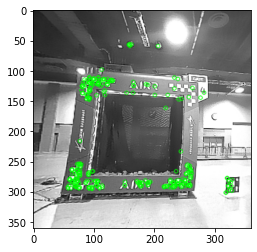

In [9]:
img = cv2.drawKeypoints(queryImg, queryKp, outImage=None, color=(0,255,0), flags=0)
plt.imshow(img)
plt.show()

In [80]:
# Initialize the BF Matcher
# matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

# Initialize the Flann Matcher
index_params = dict(algorithm=6,
                    table_number=6,
                    key_size=12,
                    multi_probe_level=2)
search_params = {}
matcher = cv2.FlannBasedMatcher(index_params, search_params)

# matches = matcher.match(queryDes, trainDes)
matches = matcher.knnMatch(queryDes, trainDes, k=8)
print(len(matches))
# matches = sorted(matches, key = lambda x:x.distance)

# store all the good matches as per Lowe's ratio test.
# NOTE: MANUAL TRICK: POPULARITY, SIMILARITY AND OUTPERFORM THE SECOND CANDIDATE
good_matches = []
for candidates in matches:
    scores = np.zeros((len(candidates),))
    vert_popularity = np.zeros((len(candidates),))
    vert_similarity = np.zeros((len(candidates),))
    query_y = (queryKp[candidates[0].queryIdx].pt)[1] # NOTE: m.queryIdx == n.queryIdx
    for idx, candidate in enumerate(candidates):
        scores[idx] = candidate.distance
        train_cy = (trainKp[candidate.trainIdx].pt)[1]
        vert_popularity[idx] = train_cy
#         if train_cy
        vert_similarity[idx] = abs(query_y - train_cy)
    vert_popularity = abs(vert_popularity - np.median(vert_popularity))
#     print(scores)
#     print(vert_scores)
    scores += 0*vert_popularity + 1*vert_similarity
    scores = -scores
    scores -= np.min(scores)
#     print(scores)
#     break
    best_candidate = np.argmax(scores)
    best_score = scores[best_candidate]
    scores[best_candidate] = float('-inf')
    second_candidate = np.argmax(scores)
    if best_score > 1.25 * scores[second_candidate]:
        good_matches.append(candidates[best_candidate])
#     break
# good_matches = matches[:50]
print(len(good_matches))

300
128


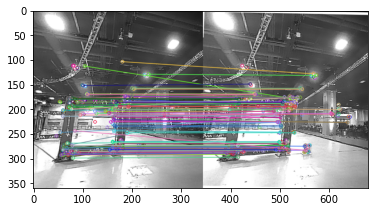

In [81]:
# draw the matches
img_match = cv2.drawMatches(queryImg, queryKp, trainImg, trainKp, good_matches, None)
# img_match = cv2.resize(img_match, (1000,650))

# Show the matched image
# cv2.imshow("Matches", final_img)
plt.imshow(img_match)
plt.show()

In [82]:
MIN_MATCH_COUNT = 10

if len(good_matches) > MIN_MATCH_COUNT:
    src_pts = np.float32([queryKp[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([trainKp[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    h,w = queryImg.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    trainImg = cv2.polylines(trainImg,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    
    corrected_img = cv2.warpPerspective(maskImg, M, (trainImg.shape[1], trainImg.shape[0]))

else:
    print("Not enough matches are found - %d/%d" % (len(good_matches),MIN_MATCH_COUNT))
    matchesMask = None

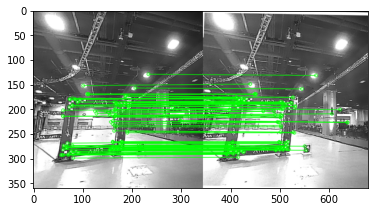

In [83]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(queryImg, queryKp, trainImg, trainKp, good_matches, None, **draw_params)

plt.imshow(img3, 'gray')
plt.show()

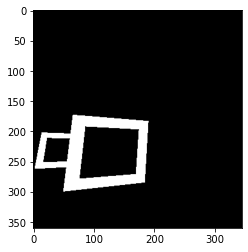

In [78]:
plt.imshow(maskImg, 'gray')
plt.show()

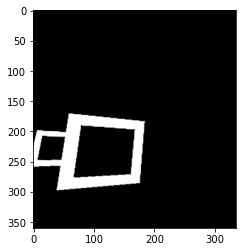

In [79]:
plt.imshow(corrected_img, 'gray')
plt.show()